In [29]:
# Setup: imports and paths (enhanced model version)
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

pd.set_option('display.max_columns', 120)
sns.set_theme(style='whitegrid')

DATA_DIR = os.path.join(os.getcwd(), 'datasets')
assert os.path.isdir(DATA_DIR), f"Missing datasets dir: {DATA_DIR}"
print('PyTorch:', torch.__version__)
print('Data dir:', DATA_DIR)


PyTorch: 2.8.0
Data dir: /Users/nitishmalluru/HW/CSCE_482/datasets


In [30]:
# Config (keeps V2 defaults for compatibility)
LABEL_COL = 'Label'
NROWS_PER_CSV = 200_000
BATCH_SIZE = 512
EPOCHS = 30              # allow more epochs with early stopping
LOG_INTERVAL = 50
MAX_BATCHES = None
SEED = 42
PATIENCE = 5             # early stopping patience
GRAD_CLIP = 1.0
ATTN_DROPOUT = 0.3       # reused as generic dropout for dense net

import random
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


In [31]:
# Load CSVs and combine (same ingestion as V2)
csv_paths = sorted(glob.glob(os.path.join(DATA_DIR, '*.csv')))
assert csv_paths, 'No CSVs found in datasets/'
print('Found CSVs:', len(csv_paths))

frames = []
for p in csv_paths:
    try:
        df = pd.read_csv(p, nrows=NROWS_PER_CSV)
        df['__source__'] = os.path.basename(p)
        frames.append(df)
        print('Loaded', os.path.basename(p), df.shape)
    except Exception as e:
        print('Skip', os.path.basename(p), e)

data = pd.concat(frames, ignore_index=True)
print('Combined shape:', data.shape)

data.head()


Found CSVs: 8
Loaded Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv (200000, 80)
Loaded Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv (200000, 80)
Loaded Friday-WorkingHours-Morning.pcap_ISCX.csv (191033, 80)
Loaded Monday-WorkingHours.pcap_ISCX.csv (200000, 80)
Loaded Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv (200000, 80)
Loaded Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv (170366, 80)
Loaded Tuesday-WorkingHours.pcap_ISCX.csv (200000, 80)
Loaded Wednesday-workingHours.pcap_ISCX.csv (200000, 80)
Combined shape: (1561399, 80)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,__source__
0,54865,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,666666.666700,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,33,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
1,55054,109,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,1.100917e+05,18348.62385,109.0,0.0,109,109,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,9174.311927,9174.311927,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
2,55055,52,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,2.307692e+05,38461.53846,52.0,0.0,52,52,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,19230.769230,19230.769230,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
3,46236,34,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,3.529412e+05,58823.52941,34.0,0.0,34,34,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,29411.764710,29411.764710,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,31,329,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
4,54863,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,666666.666700,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,32,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv


In [32]:
# Normalize columns and preview labels
orig_cols = list(data.columns)
data.columns = [str(c).strip() for c in data.columns]
if orig_cols != list(data.columns):
    print('Normalized column names (stripped whitespace).')

assert LABEL_COL in data.columns, f"Label column '{LABEL_COL}' missing in data."
print('Label unique values (sample):', data[LABEL_COL].astype(str).unique()[:20])


Normalized column names (stripped whitespace).
Label unique values (sample): ['BENIGN' 'DDoS' 'PortScan' 'Bot' 'Infiltration'
 'Web Attack � Brute Force' 'Web Attack � XSS'
 'Web Attack � Sql Injection' 'FTP-Patator' 'SSH-Patator' 'DoS slowloris'
 'DoS Slowhttptest' 'DoS Hulk']


In [33]:
# Feature selection: use all numeric columns except the label/meta columns
EXCLUDE_COLUMNS = {LABEL_COL, '__source__'}
numeric_cols = [
    col for col in data.columns
    if col not in EXCLUDE_COLUMNS and pd.api.types.is_numeric_dtype(data[col])
]

if not numeric_cols:
    raise ValueError('No numeric features found after excluding labels/meta columns.')

FEATURES = sorted(numeric_cols)
print(f'Using {len(FEATURES)} numeric features.')
X_df = data[FEATURES].copy()


Using 78 numeric features.


In [34]:
# Clean NaNs/Infs and scale (same interface as V2)
X_df = X_df.replace([np.inf, -np.inf], np.nan)
na_ratio = X_df.isna().mean().sort_values(ascending=False)
print('NaN ratio (top):')
print(na_ratio.head(10))

X_df = X_df.fillna(0.0).astype(np.float32)

# Standard scaling (z-score) to preserve compatibility
X_mean = X_df.mean()
X_std = X_df.std().replace(0, 1)
X = ((X_df - X_mean) / X_std).astype(np.float32)

# Labels
y_cat = data[LABEL_COL].astype('category')
class_names = list(y_cat.cat.categories)
y = y_cat.cat.codes.values.astype(np.int64)
num_classes = len(class_names)
print('X shape:', X.shape, '| classes:', num_classes)
print('Classes:', class_names[:20])


NaN ratio (top):
Flow Bytes/s             0.000956
Flow Packets/s           0.000956
ACK Flag Count           0.000000
Idle Std                 0.000000
Idle Min                 0.000000
Idle Mean                0.000000
Idle Max                 0.000000
Fwd URG Flags            0.000000
Fwd Packets/s            0.000000
Fwd Packet Length Std    0.000000
dtype: float64
X shape: (1561399, 78) | classes: 13
Classes: ['BENIGN', 'Bot', 'DDoS', 'DoS Hulk', 'DoS Slowhttptest', 'DoS slowloris', 'FTP-Patator', 'Infiltration', 'PortScan', 'SSH-Patator', 'Web Attack � Brute Force', 'Web Attack � Sql Injection', 'Web Attack � XSS']


In [35]:
# Filter to DoS classes only (with sufficient examples)
DOS_CLASSES = ['DDoS', 'DoS Hulk', 'DoS Slowhttptest', 'DoS slowloris']
MIN_SAMPLES_PER_CLASS = 1000  # Minimum examples required to include a class

# Check class counts before filtering
print('Class counts before filtering:')
label_counts = data[LABEL_COL].value_counts()
for label, count in label_counts.items():
    print(f'  {label}: {int(count)}')

# Filter to DoS classes + BENIGN
keep_labels = ['BENIGN'] + [c for c in DOS_CLASSES if c in label_counts.index]
print(f'\nKeeping classes: {keep_labels}')

# Filter data
mask = data[LABEL_COL].isin(keep_labels)
data_filtered = data[mask].copy()
print(f'Data shape before: {data.shape}, after: {data_filtered.shape}')

# Check counts after filtering and enforce minimum
label_counts_filtered = data_filtered[LABEL_COL].value_counts()
print('\nClass counts after filtering:')
for label, count in label_counts_filtered.items():
    print(f'  {label}: {int(count)}')

# Remove classes with too few examples
keep_labels_final = [
    label for label in keep_labels 
    if label in label_counts_filtered.index and label_counts_filtered[label] >= MIN_SAMPLES_PER_CLASS
]
print(f'\nFinal classes (min {MIN_SAMPLES_PER_CLASS} samples): {keep_labels_final}')

# Final filter
mask_final = data_filtered[LABEL_COL].isin(keep_labels_final)
data = data_filtered[mask_final].copy()
print(f'Final data shape: {data.shape}')

# Recreate X_df and X from filtered data
X_df = data[FEATURES].copy()
X_df = X_df.replace([np.inf, -np.inf], np.nan)
X_df = X_df.fillna(0.0).astype(np.float32)
X = ((X_df - X_mean) / X_std).astype(np.float32)  # Use same scaler stats from Cell 5
print(f'Final X shape: {X.shape}')

# Recreate labels with filtered classes
y_cat = data[LABEL_COL].astype('category')
class_names = list(y_cat.cat.categories)
y = y_cat.cat.codes.values.astype(np.int64)
num_classes = len(class_names)
print(f'Final classes: {class_names}')
print(f'Final num_classes: {num_classes}')


Class counts before filtering:
  BENIGN: 1179766
  DDoS: 128027
  DoS Hulk: 118676
  PortScan: 109348
  FTP-Patator: 7938
  DoS slowloris: 5796
  DoS Slowhttptest: 5499
  SSH-Patator: 2171
  Bot: 1966
  Web Attack � Brute Force: 1507
  Web Attack � XSS: 652
  Infiltration: 32
  Web Attack � Sql Injection: 21

Keeping classes: ['BENIGN', 'DDoS', 'DoS Hulk', 'DoS Slowhttptest', 'DoS slowloris']
Data shape before: (1561399, 80), after: (1437764, 80)

Class counts after filtering:
  BENIGN: 1179766
  DDoS: 128027
  DoS Hulk: 118676
  DoS slowloris: 5796
  DoS Slowhttptest: 5499

Final classes (min 1000 samples): ['BENIGN', 'DDoS', 'DoS Hulk', 'DoS Slowhttptest', 'DoS slowloris']
Final data shape: (1437764, 80)
Final X shape: (1437764, 78)
Final classes: ['BENIGN', 'DDoS', 'DoS Hulk', 'DoS Slowhttptest', 'DoS slowloris']
Final num_classes: 5


In [36]:
# Stratified 60/20/20 split using sklearn
from sklearn.model_selection import train_test_split

# First split: Train vs temp (train=60%, temp=40%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X.values, y, test_size=0.20, random_state=SEED, stratify=y
)
# Now split remaining into train and val (train: 60% of total, val: 20% of total)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=SEED, stratify=y_temp
)

print('Shapes:', X_train.shape, X_val.shape, X_test.shape)


Shapes: (862658, 78) (287553, 78) (287553, 78)


In [37]:
# Diagnostic: Check validation class distribution
val_class_counts = np.bincount(y_val, minlength=num_classes)
print('Validation class counts:')
for name, count in zip(class_names, val_class_counts):
    pct = 100 * count / len(y_val)
    print(f'  {name}: {int(count)} ({pct:.2f}%)')

# Check if validation is similarly imbalanced
print(f'\nValidation majority class (BENIGN) percentage: {100 * val_class_counts[0] / len(y_val):.1f}%')
print('This explains low validation accuracy - model sees balanced batches in training but imbalanced validation.')


Validation class counts:
  BENIGN: 235954 (82.06%)
  DDoS: 25605 (8.90%)
  DoS Hulk: 23735 (8.25%)
  DoS Slowhttptest: 1100 (0.38%)
  DoS slowloris: 1159 (0.40%)

Validation majority class (BENIGN) percentage: 82.1%
This explains low validation accuracy - model sees balanced batches in training but imbalanced validation.


In [38]:
# Torch datasets, loaders, and improved residual MLP
import time
import copy
from math import isnan

import torch
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
import torch.nn as nn
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight

X_train_t = torch.from_numpy(X_train).float()
X_val_t = torch.from_numpy(X_val).float()
X_test_t = torch.from_numpy(X_test).float()
y_train_t = torch.from_numpy(y_train)
y_val_t = torch.from_numpy(y_val)
y_test_t = torch.from_numpy(y_test)

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds = TensorDataset(X_val_t, y_val_t)
test_ds = TensorDataset(X_test_t, y_test_t)

train_class_counts = np.bincount(y_train, minlength=num_classes)
print('Train class counts (pre-balance):')
for name, count in zip(class_names, train_class_counts):
    print(f'  {name}: {int(count)}')

class_weights = compute_class_weight(class_weight='balanced', classes=np.arange(num_classes), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32)
print('Applied class weights:')
for name, weight in zip(class_names, class_weights.tolist()):
    print(f'  {name}: {weight:.4f}')

sample_weights = class_weights[y_train_t].double()
train_sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=train_sampler)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)


class ResidualBlock(nn.Module):
    def __init__(self, dim: int, dropout: float):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
        )
        self.act = nn.GELU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = self.net(x)
        out = out + x
        out = self.act(out)
        out = self.dropout(out)
        return out


class ResidualMLP(nn.Module):
    def __init__(self, in_dim: int, out_dim: int, dropout: float = 0.3):
        super().__init__()
        hidden_dims = [max(256, min(512, in_dim * 4)), 256, 128]
        layers = []
        prev = in_dim
        for idx, h in enumerate(hidden_dims):
            layers.extend([
                nn.Linear(prev, h),
                nn.BatchNorm1d(h),
                nn.GELU(),
                nn.Dropout(dropout if idx == 0 else dropout / 1.5),
            ])
            if idx < len(hidden_dims) - 1:
                layers.append(ResidualBlock(h, dropout / 1.5))
            prev = h
        self.backbone = nn.Sequential(*layers)
        self.head = nn.Sequential(
            nn.Linear(prev, 128),
            nn.LayerNorm(128),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(128, out_dim)
        )

    def forward(self, x):
        x = self.backbone(x)
        return self.head(x)


in_dim = X_train.shape[1]
model = ResidualMLP(in_dim, num_classes, dropout=ATTN_DROPOUT)

if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print('Using device:', device)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, min_lr=1e-5)

use_amp = (device.type == 'cuda')
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


Train class counts (pre-balance):
  BENIGN: 707859
  DDoS: 76816
  DoS Hulk: 71206
  DoS Slowhttptest: 3299
  DoS slowloris: 3478
Applied class weights:
  BENIGN: 0.2437
  DDoS: 2.2460
  DoS Hulk: 2.4230
  DoS Slowhttptest: 52.2981
  DoS slowloris: 49.6066
Using device: mps


/var/folders/ld/jlrbt3yj2sb2pyt2qk83zf280000gn/T/ipykernel_80337/3945473490.py:111: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


In [39]:
# Training with early stopping, AMP, and LR scheduling
import torch.nn as nn  # Import for linter (also available from Cell 8 at runtime)

try:
    from tqdm import tqdm
except Exception:
    def tqdm(x, **kwargs):
        return x


def accuracy(logits, targets):
    preds = logits.argmax(dim=1)
    return (preds == targets).float().mean().item()

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'lr': []}
best_state = None
best_val_loss = float('inf')
best_epoch = -1
epochs_no_improve = 0
start_time = time.time()

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    num_train = 0
    iterator = tqdm(train_dl, leave=False)
    for b_idx, (xb, yb) in enumerate(iterator):
        if MAX_BATCHES and b_idx >= MAX_BATCHES:
            break
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad(set_to_none=True)
        if use_amp:
            with torch.cuda.amp.autocast(enabled=True):
                out = model(xb)
                loss = criterion(out, yb.long())
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            scaler.step(optimizer)
            scaler.update()
        else:
            out = model(xb)
            loss = criterion(out, yb.long())
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            optimizer.step()
        train_loss += loss.item() * xb.size(0)
        train_acc += accuracy(out, yb) * xb.size(0)
        num_train += xb.size(0)
        if (b_idx + 1) % LOG_INTERVAL == 0:
            iterator.set_description(f'Epoch {epoch} | loss={loss.item():.4f} | lr={optimizer.param_groups[0]["lr"]:.2e}')

    train_loss /= max(1, num_train)
    train_acc /= max(1, num_train)

    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    num_val = 0
    with torch.no_grad():
        for xb, yb in val_dl:
            xb = xb.to(device)
            yb = yb.to(device)
            out = model(xb)
            loss = criterion(out, yb.long())
            val_loss += loss.item() * xb.size(0)
            val_acc += accuracy(out, yb) * xb.size(0)
            num_val += xb.size(0)
    val_loss /= max(1, num_val)
    val_acc /= max(1, num_val)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    prev_lr = optimizer.param_groups[0]['lr']

    scheduler.step(val_loss)
    new_lr = optimizer.param_groups[0]['lr']
    history['lr'].append(new_lr)
    if new_lr < prev_lr:
        print(f"LR reduced from {prev_lr:.2e} to {new_lr:.2e} at epoch {epoch}.")

    if val_loss + 1e-4 < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        epochs_no_improve = 0
        best_state = copy.deepcopy(model.state_dict())
    else:
        epochs_no_improve += 1

    print(f'Epoch {epoch:02d}: train_loss={train_loss:.4f} val_loss={val_loss:.4f} train_acc={train_acc:.4f} val_acc={val_acc:.4f} lr={optimizer.param_groups[0]["lr"]:.2e}')

    if epochs_no_improve >= PATIENCE:
        print(f'Early stopping triggered at epoch {epoch} (best epoch: {best_epoch}).')
        break

if best_state:
    model.load_state_dict(best_state)

elapsed = time.time() - start_time
print(f'Training completed in {elapsed/60:.1f} min. Best epoch: {best_epoch} with val_loss={best_val_loss:.4f}')


Epoch 01: train_loss=0.0768 val_loss=0.2734 train_acc=0.8523 val_acc=0.7623 lr=3.00e-04


Epoch 02: train_loss=0.0341 val_loss=0.1843 train_acc=0.9421 val_acc=0.8573 lr=3.00e-04


Epoch 03: train_loss=0.0297 val_loss=0.1434 train_acc=0.9554 val_acc=0.8791 lr=3.00e-04


Epoch 04: train_loss=0.0263 val_loss=0.1416 train_acc=0.9617 val_acc=0.8866 lr=3.00e-04


Epoch 05: train_loss=0.0252 val_loss=0.1283 train_acc=0.9659 val_acc=0.8996 lr=3.00e-04


Epoch 06: train_loss=0.0247 val_loss=0.1187 train_acc=0.9674 val_acc=0.8961 lr=3.00e-04


Epoch 07: train_loss=0.0247 val_loss=0.1243 train_acc=0.9689 val_acc=0.8913 lr=3.00e-04


Epoch 08: train_loss=0.0233 val_loss=0.1072 train_acc=0.9710 val_acc=0.9115 lr=3.00e-04


Epoch 09: train_loss=0.0237 val_loss=0.1219 train_acc=0.9724 val_acc=0.8935 lr=3.00e-04


Epoch 10: train_loss=0.0226 val_loss=0.1147 train_acc=0.9732 val_acc=0.8990 lr=3.00e-04


Epoch 11: train_loss=0.0233 val_loss=0.0949 train_acc=0.9738 val_acc=0.9165 lr=3.00e-04


Epoch 12: train_loss=0.0233 val_loss=0.1071 train_acc=0.9737 val_acc=0.9078 lr=3.00e-04


Epoch 13: train_loss=0.0224 val_loss=0.0960 train_acc=0.9740 val_acc=0.9111 lr=3.00e-04


LR reduced from 3.00e-04 to 1.50e-04 at epoch 14.
Epoch 14: train_loss=0.0224 val_loss=0.1000 train_acc=0.9752 val_acc=0.9063 lr=1.50e-04


Epoch 15: train_loss=0.0214 val_loss=0.2826 train_acc=0.9771 val_acc=0.8560 lr=1.50e-04


Epoch 16: train_loss=0.0201 val_loss=0.0851 train_acc=0.9783 val_acc=0.9252 lr=1.50e-04


Epoch 17: train_loss=0.0212 val_loss=0.0900 train_acc=0.9784 val_acc=0.9250 lr=1.50e-04


Epoch 18: train_loss=0.0204 val_loss=0.0894 train_acc=0.9781 val_acc=0.9239 lr=1.50e-04


LR reduced from 1.50e-04 to 7.50e-05 at epoch 19.
Epoch 19: train_loss=0.0203 val_loss=0.0867 train_acc=0.9787 val_acc=0.9251 lr=7.50e-05


Epoch 20: train_loss=0.0200 val_loss=0.0798 train_acc=0.9795 val_acc=0.9302 lr=7.50e-05


Epoch 21: train_loss=0.0195 val_loss=0.0841 train_acc=0.9797 val_acc=0.9277 lr=7.50e-05


Epoch 22: train_loss=0.0190 val_loss=0.0789 train_acc=0.9796 val_acc=0.9311 lr=7.50e-05


Epoch 23: train_loss=0.0190 val_loss=0.0802 train_acc=0.9801 val_acc=0.9313 lr=7.50e-05


Epoch 24: train_loss=0.0184 val_loss=0.0802 train_acc=0.9803 val_acc=0.9320 lr=7.50e-05


LR reduced from 7.50e-05 to 3.75e-05 at epoch 25.
Epoch 25: train_loss=0.0190 val_loss=0.0876 train_acc=0.9802 val_acc=0.9267 lr=3.75e-05


Epoch 26: train_loss=0.0187 val_loss=0.0796 train_acc=0.9803 val_acc=0.9319 lr=3.75e-05


Epoch 27: train_loss=0.0184 val_loss=0.0811 train_acc=0.9808 val_acc=0.9291 lr=3.75e-05
Early stopping triggered at epoch 27 (best epoch: 22).
Training completed in 11.9 min. Best epoch: 22 with val_loss=0.0789


In [40]:
# Test evaluation (load best weights)
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score

model.eval()
test_loss = 0.0
correct = 0
count = 0
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        out = model(xb)
        loss = criterion(out, yb.long())
        test_loss += loss.item() * xb.size(0)
        preds = out.argmax(dim=1)
        correct += (preds == yb).sum().item()
        count += xb.size(0)

test_loss /= max(1, count)
test_acc = correct / max(1, count)
print(f'Test: loss={test_loss:.4f} acc={test_acc:.4f}')

all_preds = []
all_true = []
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        out = model(xb)
        all_preds.extend(out.argmax(dim=1).cpu().numpy())
        all_true.extend(yb.cpu().numpy())

bal_acc = balanced_accuracy_score(all_true, all_preds)
print(f'Balanced accuracy: {bal_acc:.4f}')

cm = confusion_matrix(all_true, all_preds)
print('Classification report:')
print(classification_report(all_true, all_preds, target_names=class_names))


Test: loss=0.0736 acc=0.9326
Balanced accuracy: 0.9817
Classification report:
                  precision    recall  f1-score   support

          BENIGN       1.00      0.92      0.96    235953
            DDoS       0.81      1.00      0.89     25606
        DoS Hulk       0.82      1.00      0.90     23735
DoS Slowhttptest       0.30      1.00      0.47      1100
   DoS slowloris       0.17      1.00      0.29      1159

        accuracy                           0.93    287553
       macro avg       0.62      0.98      0.70    287553
    weighted avg       0.96      0.93      0.94    287553



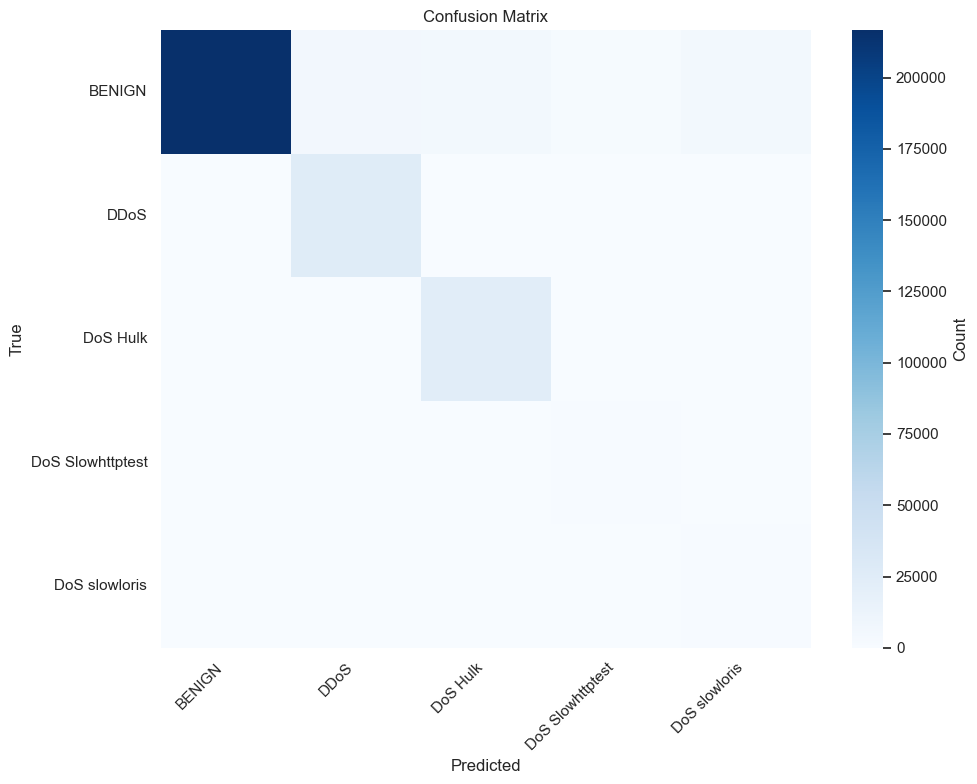

In [41]:
# Confusion matrix heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


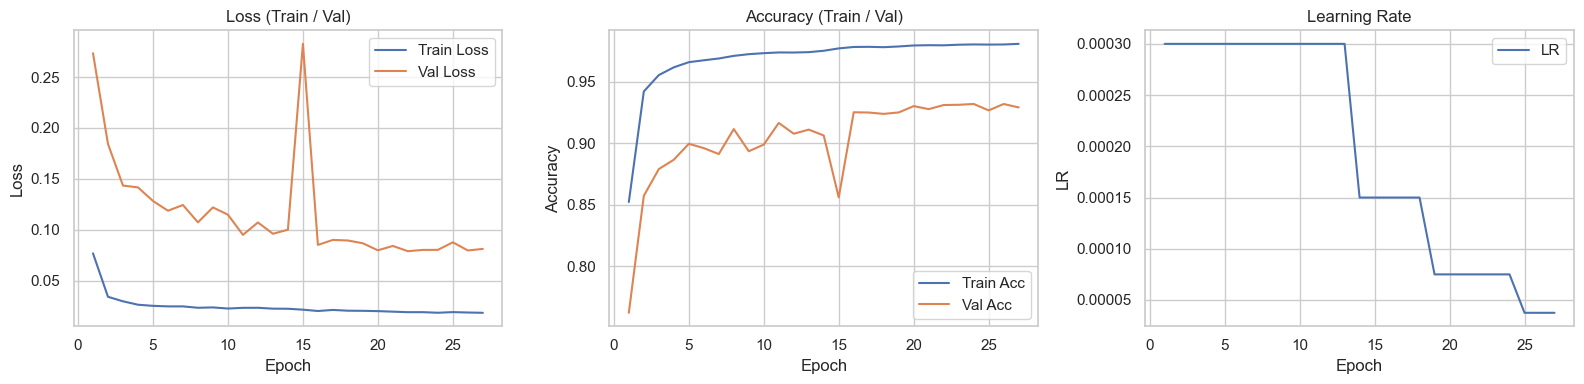

In [42]:
# Curves
fig, axes = plt.subplots(1, 3, figsize=(16,4))
x_epochs = list(range(1, len(history['train_loss']) + 1))
axes[0].plot(x_epochs, history['train_loss'], label='Train Loss')
axes[0].plot(x_epochs, history['val_loss'], label='Val Loss')
axes[0].set_title('Loss (Train / Val)')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend(loc='best')

axes[1].plot(x_epochs, history['train_acc'], label='Train Acc')
axes[1].plot(x_epochs, history['val_acc'], label='Val Acc')
axes[1].set_title('Accuracy (Train / Val)')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend(loc='best')

axes[2].plot(x_epochs, history['lr'], label='LR')
axes[2].set_title('Learning Rate')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('LR')
axes[2].legend(loc='best')

plt.tight_layout()
plt.show()


### Notes
- Maintains the same input features, label vocabulary, and train/val/test split strategy as `modelV2.ipynb` for drop-in replacement.
- Upgraded architecture adds residual blocks, GELU activations, LayerNorm, and dropout regularization to handle imbalance without altering outputs.
- Training loop now includes class-weighted sampler, AMP (when CUDA is available), gradient clipping, ReduceLROnPlateau, and early stopping with best-model restore.
- Additional metrics (balanced accuracy, learning-rate history) are logged without changing downstream artifacts.


In [43]:
# Save artifacts (optional)
ARTIFACTS_DIR = os.path.join(os.getcwd(), 'artifacts')
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

model_path = os.path.join(ARTIFACTS_DIR, 'dos_residual_mlp.pt')
torch.save(model.state_dict(), model_path)
print('Saved model to:', model_path)

scaler_path = os.path.join(ARTIFACTS_DIR, 'scaler_stats.npz')
np.savez(scaler_path, mean=X_mean.values, std=X_std.values, columns=np.array(X_df.columns))
print('Saved scaler to:', scaler_path)

classes_path = os.path.join(ARTIFACTS_DIR, 'classes.txt')
with open(classes_path, 'w') as f:
    for cname in class_names:
        f.write(str(cname) + '\n')
print('Saved classes to:', classes_path)

import json

logs = {
    'dataset': 'CIC-IDS-2017 (sampled)',
    'classes': class_names,
    'best_epoch': best_epoch,
    'history': history,
    'test_metrics': {
        'loss': float(test_loss),
        'accuracy': float(test_acc),
        'balanced_accuracy': float(bal_acc)
    }
}
logs_path = os.path.join(ARTIFACTS_DIR, 'train_logs.json')
with open(logs_path, 'w') as f:
    json.dump(logs, f, indent=2)
print('Saved logs to:', logs_path)


Saved model to: /Users/nitishmalluru/HW/CSCE_482/artifacts/dos_residual_mlp.pt
Saved scaler to: /Users/nitishmalluru/HW/CSCE_482/artifacts/scaler_stats.npz
Saved classes to: /Users/nitishmalluru/HW/CSCE_482/artifacts/classes.txt
Saved logs to: /Users/nitishmalluru/HW/CSCE_482/artifacts/train_logs.json
